In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [38]:
from pathlib import Path
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

In [4]:
%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
classification_post = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/mouse_0322R.ROICaT.classification_drawn.results.pkl')  ## from ROICaT

In [6]:
tracking_post = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/stat_and_ops.ROICaT.tracking.results.pkl')  ## from ROICaT

Text(0.5, 1.0, 'sample_silhouette')

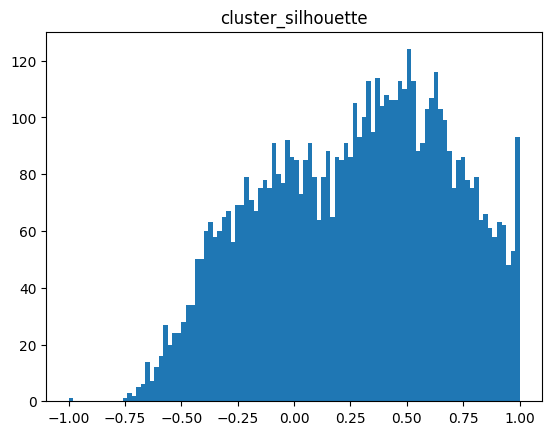

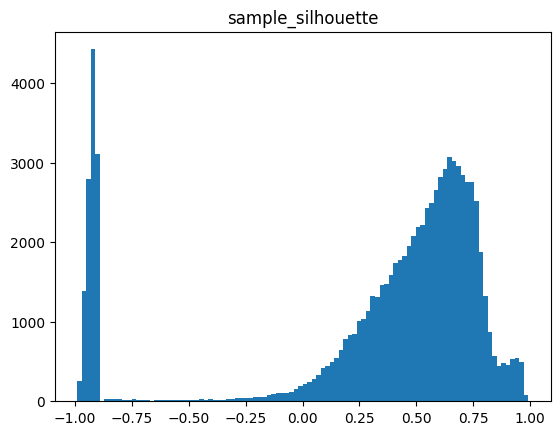

In [7]:
%matplotlib inline

plt.figure()
plt.hist(tracking_post['quality_metrics']['cluster_silhouette'], 100);
plt.title('cluster_silhouette')

plt.figure()
plt.hist(tracking_post['quality_metrics']['sample_silhouette'], 100);
plt.title('sample_silhouette')

In [8]:
dates_post = [Path(p).parts[-2] for p in tracking_post['input_data']['paths_stat']]

In [9]:
paths_iscellTqm_post = bnpm.path_helpers.find_paths(
    dir_outer=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/',
    reMatch='iscell_tqm.npy', 
    depth=4,
)
display(paths_iscellTqm_post)

['/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230419/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230420/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230424/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230425/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230426/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230427/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230428/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230429/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/20230430/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/fa

In [10]:
iscell_tqm_post_raw = {Path(p).parts[-3]: np.load(p) for p in paths_iscellTqm_post}
iscell_tqm_post = [iscell_tqm_post_raw[date] for date in dates_post]

In [11]:
ucids_unique_post = np.unique(tracking_post['clusters']['labels'])
iscell_ucids_post = tracking_post['quality_metrics']['cluster_silhouette'] > -0.3
assert len(ucids_unique_post == iscell_ucids_post)

ucids_badQuality_post = tracking_post['quality_metrics']['cluster_labels_unique'][~iscell_ucids_post]

In [12]:
iscell_rois_post = tracking_post['quality_metrics']['sample_silhouette'] > 0.2

nROIs_bySession_cumsum = np.cumsum([0] + [len(l) for l in tracking_post['clusters']['labels_bySession']]).astype(np.int64)
iscell_rois_post = [tracking_post['quality_metrics']['sample_silhouette'][n:nROIs_bySession_cumsum[ii+1]] > 0.0 for ii, n in enumerate(nROIs_bySession_cumsum[:-1])]

In [13]:
def find_and_replace_values(arr, vals_find, val_replace):
    arr_out = np.array(arr, dtype=np.int64).copy()
    arr_out[np.isin(arr_out, vals_find)] = val_replace
    return arr_out

In [14]:
ucids_processed_post = [np.array(l, dtype=np.int64) for l in tracking_post['clusters']['labels_bySession']]

In [15]:
[np.place(arr=u, mask=~ic, vals=-1) for u, ic in zip(ucids_processed_post, iscell_rois_post)];

In [16]:
ucids_processed_post = [find_and_replace_values(l, vals_find=ucids_badQuality_post, val_replace=-1) for l in ucids_processed_post]

In [17]:
ucids_processed_post = roicat.util.mask_UCIDs_with_iscell(
    ucids=ucids_processed_post,
    iscell=classification_post['preds'],
)

In [19]:
ucids_processed_post = roicat.util.mask_UCIDs_with_iscell(
    ucids=ucids_processed_post,
    iscell=iscell_tqm_post,
)

In [20]:
ucids_processed_post = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=ucids_processed_post,
    n_sesh_thresh=4,
)

INFO: 69.23% of UCIDs in first session appear in at least 4 sessions.


In [21]:
ucids_processed_post = roicat.util.squeeze_UCID_labels(
    ucids=ucids_processed_post,
)

get dFoF

In [22]:
dFoFs = {date: np.load(Path(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_and_tqm/') / date / 'jobNum_0' / 'dFoF.npy', mmap_mode='r') for date in dates_post}

In [23]:
assert len(ucids_processed_post) == len(dFoFs)

In [24]:
dFoF_aligned = roicat.util.match_arrays_with_ucids(
    arrays=list(dFoFs.values()),
    ucids=ucids_processed_post,
    squeeze=True,
)

In [25]:
display(dFoF_aligned[0].shape)

(369, 108000)

/media/rich/Home_Linux_partition/github_repos/ROICaT/roicat/visualization.py:231: RuntimeWarning: divide by zero encountered in divide
  rois = rois.multiply(1.0/rois.max(1).A).power(1)



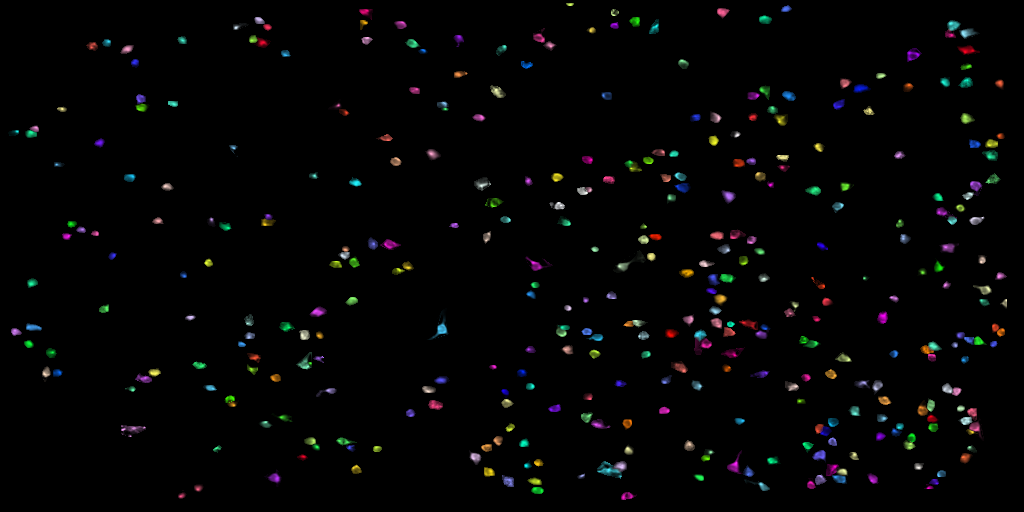

In [26]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=tracking_post['ROIs']['ROIs_aligned'],
    FOV_height=tracking_post['ROIs']['frame_height'],
    FOV_width=tracking_post['ROIs']['frame_width'],
    labels=ucids_processed_post,
)

roicat.visualization.display_toggle_image_stack(FOVs_colored,)

save aligned dF/F arrays

In [27]:
dir_save = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/'

In [28]:
for d, dfof in tqdm(zip(dates_post, dFoF_aligned)):
    path = str(Path(dir_save).resolve() / d / 'dFoF_aligned .npy')
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    np.save(path, dfof.astype(np.float32))

# If USING a Day 0 analysis package

### Condition 1: There exists a day 0 **classification** but no day 0 **tracking**: 

### Condition 2: There exists a day 0 **classification** AND a day 0 **tracking**: `iscell_classifier_matching_tqm.pkl`
- Generally, the UCIDs from this file will have been applied to the last day 0's dFoF to create the factor weights in the decoder definition notebook. So we need to figure out how to apply the weights to the new tracking aligned dFoF arrays. This will be done in three steps:
1. invert factor weights using the day 0 ucids
2. apply the new tracking ucids to the inverted factor weights

In [29]:
key_day0 = '20230425'

Generally the `iscell` in this case is the union of both the day 0 tracking results and the day 0 classification results:

In [30]:
classification_day0 = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/day0_analysis/mouse_0322R.ROICaT.classification_drawn.results.DAY0_2.pkl')

In [31]:
tracking_day0 = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/day0_analysis/mouse_0322R.ROICaT.tracking.results.DAY0_2.pkl')

In [32]:
tqm_day0 = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/day0_analysis/iscell_classifier_matching_tqm.pkl')

In [33]:
weights_day0 = np.load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/day0_analysis/weights_day0.npy', allow_pickle=True)[()]

In [34]:
weights_unmixed = roicat.util.match_arrays_with_ucids_inverse(
    arrays=[weights_day0['factors'].T] * len(tqm_day0['UCIDs_classifier_matching_tqm']),
    ucids=tqm_day0['UCIDs_classifier_matching_tqm'],
    unsqueeze=True,
)[-1]

In [35]:
idx_day0 = dates_post.index(key_day0) 

dummy_arrays = [np.arange(len(l), dtype=np.float32) for l in ucids_processed_post]
dummy_arrays[idx_day0] = weights_unmixed

weights_remixed = roicat.util.match_arrays_with_ucids(
    arrays=dummy_arrays,
    ucids=ucids_processed_post,
    squeeze=True,
)[idx_day0]

In [36]:
path_save_weightsRemixed = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322R/dFoF_aligned/weights_remixed.npy'

In [37]:
np.save(path_save_weightsRemixed, weights_remixed)